## Datasets

We mainly work on two datasets. One is the original dataset from Kaggle, and the other is cropped face images that we create from the original dataset.

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


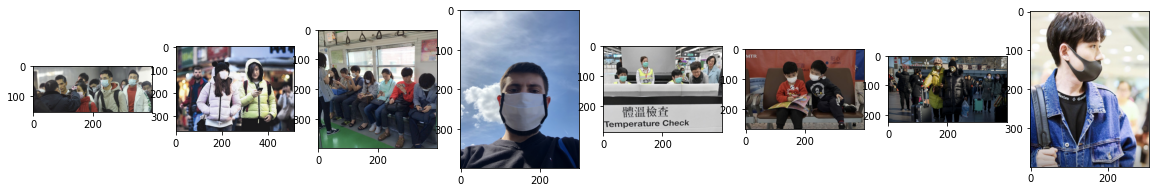

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
plt.figure(figsize=(20,10))
for i, file in enumerate(os.listdir('/content/gdrive/My Drive/ML_Project/archive/images')):
  img = cv2.cvtColor(cv2.imread('/content/gdrive/My Drive/ML_Project/archive/images/' + file), cv2.COLOR_BGR2RGB)
  plt.subplot(1, 8, i+1)
  plt.imshow(img)
  if i==7:
    break

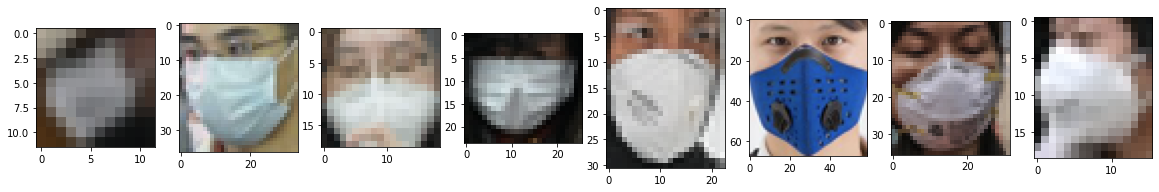

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
plt.figure(figsize=(20,10))
for i, file in enumerate(os.listdir('/content/gdrive/My Drive/ML_Project/IC dataset/train/with_mask')):
  img = cv2.cvtColor(cv2.imread('/content/gdrive/My Drive/ML_Project/IC dataset/train/with_mask/' + file), cv2.COLOR_BGR2RGB)
  plt.subplot(1, 8, i+1)
  plt.imshow(img)
  if i==7:
    break

## Proposed Methods

### c. The use of YOLOv2

We used yad2k to convert the pre-trained weights to be available on Keras. Since yad2k was implemented using older versions of tensorflow, etc. so we modified the original conversion file. The following yolo2.h5 is a file that contains the model and weights for Keras. Note that in the following, we use functions that are in the Appendix part.

In [5]:
from tensorflow.keras.models import load_model
yolov2 = load_model('/content/gdrive/My Drive/ML_Project/yolo2.h5')

/usr/local/lib/python3.7/dist-packages/keras/layers/core/lambda_layer.py:299: UserWarning: yad2k.models.keras_yolo is not loaded, but a Lambda layer uses it. It may cause errors.
  'function_type')
/usr/local/lib/python3.7/dist-packages/keras/layers/core/lambda_layer.py:304: UserWarning: yad2k.models.keras_yolo is not loaded, but a Lambda layer uses it. It may cause errors.
  'output_shape_type')


In [6]:
import tensorflow as tf
from tensorflow.keras import backend as K
from PIL import Image, ImageFont, ImageDraw
import imghdr
import colorsys
import random

person 0.70 (92, 83) (263, 353)
cell phone 0.69 (349, 178) (376, 196)
person 0.60 (59, 89) (124, 237)
handbag 0.47 (88, 304) (135, 361)
person 0.45 (433, 167) (509, 357)
person 0.44 (257, 99) (429, 343)
person 0.37 (438, 158) (500, 283)
person 0.36 (97, 93) (155, 231)
person 0.33 (59, 107) (133, 335)
backpack 0.30 (290, 136) (391, 228)


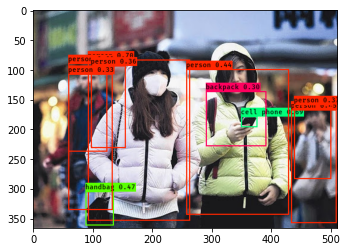

In [7]:
image_path = '/content/gdrive/My Drive/ML_Project/archive/images/maksssksksss0.png'

image, image_data = preprocess_image(image_path, (608, 608))
yolo_model_outputs = yolov2.predict(image_data)
yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)
image_with_boxes = draw_boxes(image, out_boxes, out_classes, class_names, out_scores)
plt.imshow(image_with_boxes)
plt.show()

### d. I. YOLOFACE (YOLOv3)

In [ ]:
!python "gdrive/MyDrive/ML_Project/yoloface/yoloface.py" --image "gdrive/MyDrive/ML_Project/yoloface/archive/images/maksssksksss0.png" --output-dir "content/gdrive/MyDrive/ML_Project/yoloface/outputs"

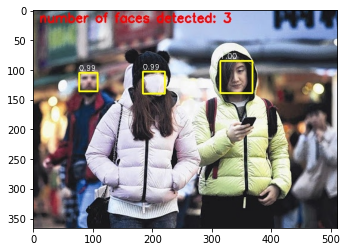

In [8]:
img = cv2.cvtColor(cv2.imread('/content/gdrive/My Drive/ML_Project/maksssksksss0_yoloface.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

## Performance

This part is for the image classification task. We first trained a model to classify "with_mask" and "without_mask". Then, we added the third class, "mask_weared_incorrectly", which has relatively small number of samples. To get the result we provided in the report, we set nepochs=10, but in the following, we set nepochs=1 because it takes long to train all the models again here.

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, BatchNormalization, LeakyReLU, Input, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.metrics import precision_recall_fscore_support

In [10]:
nrow,ncol = 50, 50

## 2-class

In [11]:
path = "/content/gdrive/My Drive/ML_Project/IC dataset"
train_data_dir = "/train"
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
                        path + train_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='binary')

test_data_dir = '/test'
test_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_generator = test_datagen.flow_from_directory(
                        path + test_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='binary'
)

Found 2843 images belonging to 2 classes.
Found 1216 images belonging to 2 classes.


In [12]:
train_generator.class_indices

{'with_mask': 0, 'without_mask': 1}

In [13]:
steps_per_epoch = train_generator.n // batch_size
validation_steps = test_generator.n // batch_size

xts, yts = np.empty((0, 50, 50, 3)), np.empty((0, 1))
for i in range(validation_steps):
  x, y = test_generator.next()
  xts = np.concatenate((xts, x))
  yts = np.concatenate((yts, y.reshape(batch_size,1)))

### Model I (2-class)

In [14]:
K.clear_session()

model = Sequential()
model.add(Conv2D(16, (3,3), strides=(1,1), padding='same', use_bias=False, activation=None, kernel_regularizer=l2(5e-4), input_shape=(nrow,ncol,3)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(32, (3,3), strides=(1,1), padding='same', use_bias=False, activation=None, kernel_regularizer=l2(5e-4)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(padding='same', pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(64, (3,3), strides=(1,1), padding='same', use_bias=False, activation=None, kernel_regularizer=l2(5e-4)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(128, (3,3), strides=(1,1), padding='same', use_bias=False, activation=None, kernel_regularizer=l2(5e-4)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Flatten())
model.add(Dense(64, activation=None))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss="binary_crossentropy", 
                      optimizer=optimizers.Adam(learning_rate=1e-3),
                      metrics=['accuracy'])

In [15]:
nepochs = 1

hist = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


88/88 [==============================] - 553s 6s/step - loss: 0.3456 - accuracy: 0.9217 - val_loss: 0.4597 - val_accuracy: 0.8988


In [16]:
yhat = model.predict(xts)
yhat[yhat<0.5] = 0
yhat[yhat>=0.5] = 1

acc = np.sum(yhat==yts) / len(yhat)
prec, rec, f1, _ = precision_recall_fscore_support(yts, yhat)
print('Accuracy: ' + str(acc))
print('Precision: ' + str(prec))
print('Recall: ' + str(rec))
print('F1: '+ str(f1))

Accuracy: 0.899671052631579
Precision: [0.97967914 0.63345196]
Recall: [0.89892051 0.9035533 ]
F1: [0.93756397 0.74476987]


### Model II (2-class)

In [17]:
K.clear_session()

model = Sequential()
model.add(Conv2D(16, (3,3), strides=(1,1), padding='same', use_bias=True, activation='relu', kernel_regularizer=l2(5e-4), input_shape=(nrow,ncol,3)))
model.add(Conv2D(32, (3,3), strides=(1,1), padding='same', use_bias=True, activation='relu', kernel_regularizer=l2(5e-4)))
model.add(Conv2D(64, (3,3), strides=(1,1), padding='same', use_bias=True, activation='relu', kernel_regularizer=l2(5e-4)))
model.add(Conv2D(128, (3,3), strides=(1,1), padding='same', use_bias=True, activation='relu', kernel_regularizer=l2(5e-4)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss="binary_crossentropy", 
                      optimizer=optimizers.Adam(learning_rate=1e-3),
                      metrics=['accuracy'])

In [18]:
nepochs = 1

hist = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


88/88 [==============================] - 132s 1s/step - loss: 0.3999 - accuracy: 0.8990 - val_loss: 0.1324 - val_accuracy: 0.9753


In [19]:
yhat = model.predict(xts)
yhat[yhat<0.5] = 0
yhat[yhat>=0.5] = 1

acc = np.sum(yhat==yts) / len(yhat)
prec, rec, f1, _ = precision_recall_fscore_support(yts, yhat)
print('Accuracy: ' + str(acc))
print('Precision: ' + str(prec))
print('Recall: ' + str(rec))
print('F1: '+ str(f1))

Accuracy: 0.9769736842105263
Precision: [0.98721731 0.92462312]
Recall: [0.98527969 0.93401015]
F1: [0.98624754 0.92929293]


### Model III (2-class)

In [20]:
K.clear_session()

model = Sequential()
model.add(Conv2D(16, (3,3), strides=(1,1), padding='same', use_bias=True, activation='relu', kernel_regularizer=l2(5e-4), input_shape=(nrow,ncol,3)))
model.add(Conv2D(32, (3,3), strides=(1,1), padding='same', use_bias=True, activation='relu', kernel_regularizer=l2(5e-4)))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss="binary_crossentropy", 
                      optimizer=optimizers.Adam(learning_rate=1e-3),
                      metrics=['accuracy'])

In [21]:
nepochs = 1

hist = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


88/88 [==============================] - 23s 249ms/step - loss: 0.2423 - accuracy: 0.9029 - val_loss: 0.1145 - val_accuracy: 0.9638


In [22]:
yhat = model.predict(xts)
yhat[yhat<0.5] = 0
yhat[yhat>=0.5] = 1

acc = np.sum(yhat==yts) / len(yhat)
prec, rec, f1, _ = precision_recall_fscore_support(yts, yhat)
print('Accuracy: ' + str(acc))
print('Precision: ' + str(prec))
print('Recall: ' + str(rec))
print('F1: '+ str(f1))

Accuracy: 0.962171052631579
Precision: [0.96289248 0.95757576]
Recall: [0.99313052 0.80203046]
F1: [0.97777778 0.87292818]


### Model IV (2-class)

In [23]:
K.clear_session()

model = Sequential()
model.add(Conv2D(4, (3,3), strides=(1,1), padding='same', use_bias=True, activation='relu', kernel_regularizer=l2(5e-4), input_shape=(nrow,ncol,3)))
model.add(Conv2D(8, (3,3), strides=(1,1), padding='same', use_bias=True, activation='relu', kernel_regularizer=l2(5e-4)))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss="binary_crossentropy", 
                      optimizer=optimizers.Adam(learning_rate=1e-3),
                      metrics=['accuracy'])

In [24]:
nepochs = 1

hist = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


88/88 [==============================] - 17s 186ms/step - loss: 0.4274 - accuracy: 0.7990 - val_loss: 0.2909 - val_accuracy: 0.8651


In [25]:
yhat = model.predict(xts)
yhat[yhat<0.5] = 0
yhat[yhat>=0.5] = 1

acc = np.sum(yhat==yts) / len(yhat)
prec, rec, f1, _ = precision_recall_fscore_support(yts, yhat)
print('Accuracy: ' + str(acc))
print('Precision: ' + str(prec))
print('Recall: ' + str(rec))
print('F1: '+ str(f1))

Accuracy: 0.8634868421052632
Precision: [0.87248908 0.71830986]
Recall: [0.98037291 0.25888325]
F1: [0.9232902  0.38059701]


### Model V (2-class)

In [26]:
K.clear_session()

model = Sequential()
model.add(Conv2D(4, (3,3), strides=(1,1), padding='same', use_bias=True, activation='relu', input_shape=(nrow,ncol,3)))
model.add(Flatten())
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss="binary_crossentropy", 
                      optimizer=optimizers.Adam(learning_rate=1e-3),
                      metrics=['accuracy'])

In [27]:
nepochs = 1

hist = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


88/88 [==============================] - 24s 271ms/step - loss: 0.3594 - accuracy: 0.8413 - val_loss: 0.0982 - val_accuracy: 0.9712


In [28]:
yhat = model.predict(xts)
yhat[yhat<0.5] = 0
yhat[yhat>=0.5] = 1

acc = np.sum(yhat==yts) / len(yhat)
prec, rec, f1, _ = precision_recall_fscore_support(yts, yhat)
print('Accuracy: ' + str(acc))
print('Precision: ' + str(prec))
print('Recall: ' + str(rec))
print('F1: '+ str(f1))

Accuracy: 0.9695723684210527
Precision: [0.98710317 0.88461538]
Recall: [0.9764475  0.93401015]
F1: [0.98174642 0.90864198]


### Model VI (2-class)

In [29]:
K.clear_session()

model = Sequential()
model.add(Input(shape=(nrow,ncol,3)))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss="binary_crossentropy", 
                      optimizer=optimizers.Adam(learning_rate=1e-3),
                      metrics=['accuracy'])

In [30]:
nepochs = 1

hist = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


88/88 [==============================] - 14s 141ms/step - loss: 0.3976 - accuracy: 0.7972 - val_loss: 0.2675 - val_accuracy: 0.8380


In [31]:
yhat = model.predict(xts)
yhat[yhat<0.5] = 0
yhat[yhat>=0.5] = 1

acc = np.sum(yhat==yts) / len(yhat)
prec, rec, f1, _ = precision_recall_fscore_support(yts, yhat)
print('Accuracy: ' + str(acc))
print('Precision: ' + str(prec))
print('Recall: ' + str(rec))
print('F1: '+ str(f1))

Accuracy: 0.8379934210526315
Precision: [0.83799342 0.        ]
Recall: [1. 0.]
F1: [0.91185682 0.        ]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Model VII (2-class)

In [32]:
K.clear_session()

model = Sequential()
model.add(Input(shape=(nrow,ncol,3)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss="binary_crossentropy", 
                      optimizer=optimizers.Adam(learning_rate=1e-3),
                      metrics=['accuracy'])

In [33]:
nepochs = 1

hist = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


88/88 [==============================] - 12s 129ms/step - loss: 0.7432 - accuracy: 0.7378 - val_loss: 0.3838 - val_accuracy: 0.8380


In [34]:
yhat = model.predict(xts)
yhat[yhat<0.5] = 0
yhat[yhat>=0.5] = 1

acc = np.sum(yhat==yts) / len(yhat)
prec, rec, f1, _ = precision_recall_fscore_support(yts, yhat)
print('Accuracy: ' + str(acc))
print('Precision: ' + str(prec))
print('Recall: ' + str(rec))
print('F1: '+ str(f1))

Accuracy: 0.8379934210526315
Precision: [0.83799342 0.        ]
Recall: [1. 0.]
F1: [0.91185682 0.        ]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 3-class

In [36]:
path = "/content/gdrive/My Drive/ML_Project/IC dataset"
train_data_dir = "/train"
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
                        path + train_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='categorical')

test_data_dir = '/test'
test_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_generator = test_datagen.flow_from_directory(
                        path + test_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='categorical'
)

Found 2921 images belonging to 3 classes.
Found 1261 images belonging to 3 classes.


In [37]:
xts, yts = np.empty((0, 50, 50, 3)), np.empty((0, 3))
for i in range(validation_steps):
  x, y = test_generator.next()
  xts = np.concatenate((xts, x))
  yts = np.concatenate((yts, y))
yts = np.argmax(yts, axis=1)

### Model I (3-class)

In [38]:
K.clear_session()

model = Sequential()
model.add(Conv2D(16, (3,3), strides=(1,1), padding='same', use_bias=False, activation=None, kernel_regularizer=l2(5e-4), input_shape=(nrow,ncol,3)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(32, (3,3), strides=(1,1), padding='same', use_bias=False, activation=None, kernel_regularizer=l2(5e-4)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(padding='same', pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(64, (3,3), strides=(1,1), padding='same', use_bias=False, activation=None, kernel_regularizer=l2(5e-4)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(128, (3,3), strides=(1,1), padding='same', use_bias=False, activation=None, kernel_regularizer=l2(5e-4)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Flatten())
model.add(Dense(64, activation=None))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(3, activation='softmax'))

model.compile(loss="categorical_crossentropy", 
                      optimizer=optimizers.Adam(learning_rate=1e-3),
                      metrics=['accuracy'])

In [39]:
nepochs = 1

hist = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


88/88 [==============================] - 60s 669ms/step - loss: 0.4813 - accuracy: 0.8835 - val_loss: 0.8706 - val_accuracy: 0.6834


In [40]:
yhat = model.predict(xts)
yhat = np.argmax(yhat, axis=1)

acc = np.sum(yhat==yts) / len(yhat)
prec, rec, f1, _ = precision_recall_fscore_support(yts, yhat)
print('Accuracy: ' + str(acc))
print('Precision: ' + str(prec))
print('Recall: ' + str(rec))
print('F1: '+ str(f1))

Accuracy: 0.6866776315789473
Precision: [0.         0.98176292 0.33931777]
Recall: [0.         0.65784114 1.        ]
F1: [0.         0.78780488 0.50670241]


### Model II (3-class)

In [41]:
K.clear_session()

model = Sequential()
model.add(Conv2D(16, (3,3), strides=(1,1), padding='same', use_bias=True, activation='relu', kernel_regularizer=l2(5e-4), input_shape=(nrow,ncol,3)))
model.add(Conv2D(32, (3,3), strides=(1,1), padding='same', use_bias=True, activation='relu', kernel_regularizer=l2(5e-4)))
model.add(Conv2D(64, (3,3), strides=(1,1), padding='same', use_bias=True, activation='relu', kernel_regularizer=l2(5e-4)))
model.add(Conv2D(128, (3,3), strides=(1,1), padding='same', use_bias=True, activation='relu', kernel_regularizer=l2(5e-4)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss="categorical_crossentropy", 
                      optimizer=optimizers.Adam(learning_rate=1e-3),
                      metrics=['accuracy'])

In [42]:
nepochs = 1

hist = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


88/88 [==============================] - 129s 1s/step - loss: 0.3815 - accuracy: 0.8951 - val_loss: 0.2263 - val_accuracy: 0.9350


In [43]:
yhat = model.predict(xts)
yhat = np.argmax(yhat, axis=1)

acc = np.sum(yhat==yts) / len(yhat)
prec, rec, f1, _ = precision_recall_fscore_support(yts, yhat)
print('Accuracy: ' + str(acc))
print('Precision: ' + str(prec))
print('Recall: ' + str(rec))
print('F1: '+ str(f1))

Accuracy: 0.9342105263157895
Precision: [0.66666667 0.94520548 0.87958115]
Recall: [0.04444444 0.98370672 0.88888889]
F1: [0.08333333 0.96407186 0.88421053]


### Model III (3-class)

In [44]:
K.clear_session()

model = Sequential()
model.add(Conv2D(16, (3,3), strides=(1,1), padding='same', use_bias=True, activation='relu', kernel_regularizer=l2(5e-4), input_shape=(nrow,ncol,3)))
model.add(Conv2D(32, (3,3), strides=(1,1), padding='same', use_bias=True, activation='relu', kernel_regularizer=l2(5e-4)))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss="categorical_crossentropy", 
                      optimizer=optimizers.Adam(learning_rate=1e-3),
                      metrics=['accuracy'])

In [45]:
nepochs = 1

hist = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


88/88 [==============================] - 22s 244ms/step - loss: 0.5566 - accuracy: 0.8224 - val_loss: 0.2979 - val_accuracy: 0.9317


In [46]:
yhat = model.predict(xts)
yhat = np.argmax(yhat, axis=1)

acc = np.sum(yhat==yts) / len(yhat)
prec, rec, f1, _ = precision_recall_fscore_support(yts, yhat)
print('Accuracy: ' + str(acc))
print('Precision: ' + str(prec))
print('Recall: ' + str(rec))
print('F1: '+ str(f1))

Accuracy: 0.9317434210526315
Precision: [0.         0.956      0.81944444]
Recall: [0.         0.97352342 0.93650794]
F1: [0.         0.96468214 0.87407407]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Model IV (3-class)

In [47]:
K.clear_session()

model = Sequential()
model.add(Conv2D(4, (3,3), strides=(1,1), padding='same', use_bias=True, activation='relu', kernel_regularizer=l2(5e-4), input_shape=(nrow,ncol,3)))
model.add(Conv2D(8, (3,3), strides=(1,1), padding='same', use_bias=True, activation='relu', kernel_regularizer=l2(5e-4)))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss="categorical_crossentropy", 
                      optimizer=optimizers.Adam(learning_rate=1e-3),
                      metrics=['accuracy'])

In [48]:
nepochs = 1

hist = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


88/88 [==============================] - 17s 183ms/step - loss: 0.4262 - accuracy: 0.8460 - val_loss: 0.2571 - val_accuracy: 0.9359


In [49]:
yhat = model.predict(xts)
yhat = np.argmax(yhat, axis=1)

acc = np.sum(yhat==yts) / len(yhat)
prec, rec, f1, _ = precision_recall_fscore_support(yts, yhat)
print('Accuracy: ' + str(acc))
print('Precision: ' + str(prec))
print('Recall: ' + str(rec))
print('F1: '+ str(f1))

Accuracy: 0.9317434210526315
Precision: [0.         0.95223881 0.83412322]
Recall: [0.         0.97454175 0.93121693]
F1: [0.        0.9632612 0.88     ]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Model V (3-class)

In [50]:
K.clear_session()

model = Sequential()
model.add(Conv2D(4, (3,3), strides=(1,1), padding='same', use_bias=True, activation='relu', input_shape=(nrow,ncol,3)))
model.add(Flatten())
model.add(Dense(4, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss="categorical_crossentropy", 
                      optimizer=optimizers.Adam(learning_rate=1e-3),
                      metrics=['accuracy'])

In [51]:
nepochs = 1

hist = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


88/88 [==============================] - 14s 155ms/step - loss: 0.7355 - accuracy: 0.7605 - val_loss: 0.4610 - val_accuracy: 0.8051


In [52]:
yhat = model.predict(xts)
yhat = np.argmax(yhat, axis=1)

acc = np.sum(yhat==yts) / len(yhat)
prec, rec, f1, _ = precision_recall_fscore_support(yts, yhat)
print('Accuracy: ' + str(acc))
print('Precision: ' + str(prec))
print('Recall: ' + str(rec))
print('F1: '+ str(f1))

Accuracy: 0.8075657894736842
Precision: [0.         0.80756579 0.        ]
Recall: [0. 1. 0.]
F1: [0.         0.89353958 0.        ]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Model VI (3-class)

In [53]:
K.clear_session()

model = Sequential()
model.add(Input(shape=(nrow,ncol,3)))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss="categorical_crossentropy", 
                      optimizer=optimizers.Adam(learning_rate=1e-3),
                      metrics=['accuracy'])

In [54]:
nepochs = 1

hist = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


88/88 [==============================] - 12s 130ms/step - loss: 0.5863 - accuracy: 0.7852 - val_loss: 0.4651 - val_accuracy: 0.8076


In [55]:
yhat = model.predict(xts)
yhat = np.argmax(yhat, axis=1)

acc = np.sum(yhat==yts) / len(yhat)
prec, rec, f1, _ = precision_recall_fscore_support(yts, yhat)
print('Accuracy: ' + str(acc))
print('Precision: ' + str(prec))
print('Recall: ' + str(rec))
print('F1: '+ str(f1))

Accuracy: 0.8083881578947368
Precision: [0.         0.80873866 0.66666667]
Recall: [0.         0.99898167 0.01058201]
F1: [0.         0.89384966 0.02083333]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Model VII (3-class)

In [56]:
K.clear_session()

model = Sequential()
model.add(Input(shape=(nrow,ncol,3)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss="categorical_crossentropy", 
                      optimizer=optimizers.Adam(learning_rate=1e-3),
                      metrics=['accuracy'])

In [57]:
nepochs = 1

hist = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


88/88 [==============================] - 12s 133ms/step - loss: 1.0968 - accuracy: 0.6824 - val_loss: 0.6400 - val_accuracy: 0.8109


In [58]:
yhat = model.predict(xts)
yhat = np.argmax(yhat, axis=1)

acc = np.sum(yhat==yts) / len(yhat)
prec, rec, f1, _ = precision_recall_fscore_support(yts, yhat)
print('Accuracy: ' + str(acc))
print('Precision: ' + str(prec))
print('Recall: ' + str(rec))
print('F1: '+ str(f1))

Accuracy: 0.8075657894736842
Precision: [0.         0.80756579 0.        ]
Recall: [0. 1. 0.]
F1: [0.         0.89353958 0.        ]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Face Detection + Mask Classifier

### With YOLOv2

First, we apply the pre-trained YOLOv2 model to the sample image as we did above.

person 0.70 (92, 83) (263, 353)
cell phone 0.69 (349, 178) (376, 196)
person 0.60 (59, 89) (124, 237)
handbag 0.47 (88, 304) (135, 361)
person 0.45 (433, 167) (509, 357)
person 0.44 (257, 99) (429, 343)
person 0.37 (438, 158) (500, 283)
person 0.36 (97, 93) (155, 231)
person 0.33 (59, 107) (133, 335)
backpack 0.30 (290, 136) (391, 228)


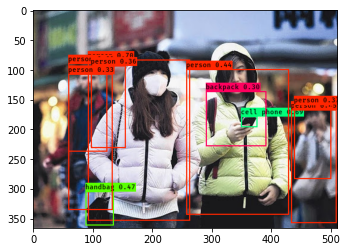

In [59]:
image_path = '/content/gdrive/My Drive/ML_Project/archive/images/maksssksksss0.png'

image, image_data = preprocess_image(image_path, (608, 608))
yolo_model_outputs = yolov2.predict(image_data)
yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)
image_with_boxes = draw_boxes(image, out_boxes, out_classes, class_names, out_scores)
plt.imshow(image_with_boxes)
plt.show()

Then, focus on a person and crop the upper part of the predicted boundary box.

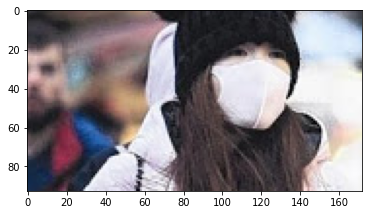

In [60]:
v2img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
bbox = np.array(out_boxes[0]).astype(int)
v2img = v2img[bbox[0]:int(bbox[2]/2), bbox[1]:bbox[3], :]
plt.imshow(v2img)
plt.show()

In [61]:
clf = load_model('/content/gdrive/My Drive/ML_Project/classifier3')

In [62]:
pred = clf.predict(cv2.resize(v2img, (50,50)).reshape(1,50,50,3))
print(pred)

[[0.]]


As we did above, train_generator.class_indices = {'with_mask': 0, 'without_mask': 1} and we can successfully detect a person and classify her into "with_mask" in this example.

### With YOLOFACE

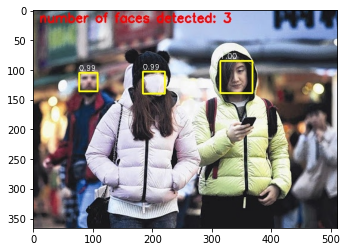

In [63]:
yfimg = cv2.cvtColor(cv2.imread('/content/gdrive/My Drive/ML_Project/maksssksksss0_yoloface.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(yfimg)
plt.show()

In the above example, we got three boundary boxes. Since the rightmost face got the highest confidence of 1.00, we foces on this face here.

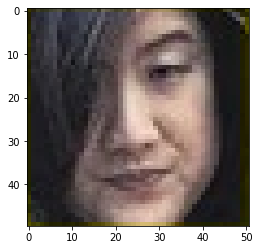

In [64]:
plt.imshow(yfimg[88:138,316:367,:])
plt.show()

In [65]:
pred = clf.predict(cv2.resize(yfimg[88:138,316:367,:], (50,50)).reshape(1,50,50,3))
print(pred)

[[1.]]


This time, the classifier predicts the label of 1, which means this face is without mask!

## Appendix

The following codes are from different blogs and codes on github that are needed to decode the prediction and the true label of YOLO.

In [4]:
def preprocess_image(img_path, model_image_size):
    image_type = imghdr.what(img_path)
    image = Image.open(img_path)
    resized_image = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)
    return image, image_data

def yolo_head(feats, anchors, num_classes):
    num_anchors = len(anchors)
    anchors_tensor = K.reshape(K.variable(anchors), [1, 1, 1, num_anchors, 2])

    conv_dims = K.shape(feats)[1:3]

    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])

    conv_width_index = K.tile(
        K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, 'float32')

    feats = K.reshape(
        feats, [-1, conv_dims[0], conv_dims[1], num_anchors, num_classes + 5])
    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats))

    box_xy = K.sigmoid(feats[..., :2])
    box_wh = K.exp(feats[..., 2:4])
    box_confidence = K.sigmoid(feats[..., 4:5])
    box_class_probs = K.softmax(feats[..., 5:])

    box_xy = (box_xy + conv_index) / conv_dims
    box_wh = box_wh * anchors_tensor / conv_dims

    return box_xy, box_wh, box_confidence, box_class_probs

def yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = 0.6):
    x = 10
    y = tf.constant(100)
    box_scores = box_class_probs*box_confidence
    box_classes = tf.math.argmax(box_scores,axis=-1)
    box_class_scores = tf.math.reduce_max(box_scores,axis=-1)
    filtering_mask = (box_class_scores >= threshold)
    scores = tf.boolean_mask(box_class_scores,filtering_mask)
    boxes = tf.boolean_mask(boxes,filtering_mask)
    classes = tf.boolean_mask(box_classes,filtering_mask)
    return scores, boxes, classes

def scale_boxes(boxes, image_shape):
    height = image_shape[0] * 1.0
    width = image_shape[1] * 1.0
    image_dims = K.stack([height, width, height, width])
    image_dims = K.reshape(image_dims, [1, 4])
    boxes = boxes * image_dims
    return boxes

def yolo_boxes_to_corners(box_xy, box_wh):
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)
    return tf.keras.backend.concatenate([box_mins[..., 1:2], box_mins[..., 0:1], box_maxes[..., 1:2], box_maxes[..., 0:1]])

def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    max_boxes_tensor = tf.Variable(max_boxes, dtype='int32')
    nms_indices = tf.image.non_max_suppression(boxes,scores,max_boxes_tensor,iou_threshold)
    scores = tf.gather(scores,nms_indices)
    boxes = tf.gather(boxes,nms_indices)
    classes = tf.gather(classes,nms_indices)
    return scores, boxes, classes

def yolo_eval(yolo_outputs, image_shape = (720, 1280), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    scores, boxes, classes = yolo_filter_boxes(boxes, box_confidence, box_class_probs, score_threshold)
    boxes = scale_boxes(boxes, image_shape)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
    return scores, boxes, classes

def get_colors_for_classes(num_classes):
    if (hasattr(get_colors_for_classes, "colors") and
            len(get_colors_for_classes.colors) == num_classes):
        return get_colors_for_classes.colors

    hsv_tuples = [(x / num_classes, 1., 1.) for x in range(num_classes)]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(
        map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
            colors))
    random.seed(10101)
    random.shuffle(colors)
    random.seed(None)
    get_colors_for_classes.colors = colors
    return colors

def draw_boxes(image, boxes, box_classes, class_names, scores=None):
    font = ImageFont.truetype(
        font='/content/gdrive/My Drive/ML_Project/font/FiraMono-Medium.otf',
        size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1]) // 300

    colors = get_colors_for_classes(len(class_names))

    for i, c in list(enumerate(box_classes)):
        box_class = class_names[c]
        box = boxes[i]
        
        if isinstance(scores.numpy(), np.ndarray):
            score = scores.numpy()[i]
            label = '{} {:.2f}'.format(box_class, score)
        else:
            label = '{}'.format(box_class)

        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        for i in range(thickness):
            draw.rectangle(
                [left + i, top + i, right - i, bottom - i], outline=colors[c])
        draw.rectangle(
            [tuple(text_origin), tuple(text_origin + label_size)],
            fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw

    return np.array(image)

with open('/content/gdrive/My Drive/ML_Project/coco_classes.txt') as f:
    class_names = f.readlines()
class_names = [c.strip() for c in class_names]

with open('/content/gdrive/My Drive/ML_Project/yolo2_anchors.txt') as f:
    anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    anchors = np.array(anchors).reshape(-1,2)